In [1]:
import numpy as np
from numba import cuda

from evolution import world

%load_ext autoreload
%autoreload 2

In [ ]:
@cuda.jit('void(int32[:], int32[:])')
def base(x, y):
    i = cuda.threadIdx.x
    y[i] = x[i] + 1

t = np.arange(16).astype(np.int32)
z = np.zeros_like(t)
print(t.dtype)
print(z)
base[1, 20](t, z)
print(z)
base[1, 20](z, z)
print(z)

In [14]:
world.main()

float32 (4, 8, 3) float32 (4, 4) float32 (4, 8, 1)


# Numba vs. Pytorch speed

In [2]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 113614.43it/s]
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 114389.07it/s]
/home/rob/anaconda3/envs/jack/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1000/1000 [00:00<00:00, 110913.48it/s]


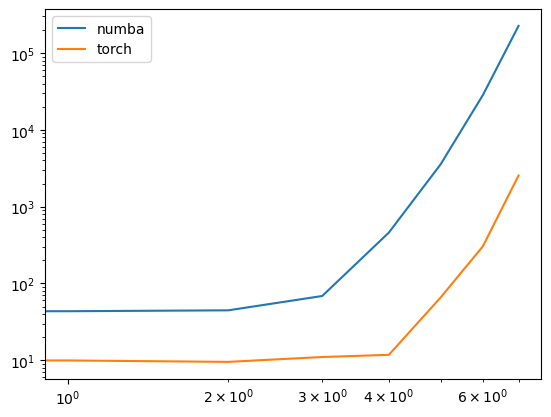

In [3]:
import torch
torch.set_grad_enabled(False)
import time
import matplotlib.pyplot as plt
from tqdm import trange

@torch.no_grad()
def trial(size):
    x = np.random.rand(size, size).astype(np.float32)
    y = np.random.rand(size, size).astype(np.float32)
    z = np.zeros((size, size)).astype(np.float32)

    d_x = cuda.to_device(x)
    d_y = cuda.to_device(y)
    d_z = cuda.to_device(z)

    t_x = torch.from_numpy(x).cuda()
    t_y = torch.from_numpy(y).cuda()

    threadsperblock = (TPB, TPB)
    blockspergrid_x = int(np.ceil(x.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(y.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    # print(blockspergrid, threadsperblock)
    fast_matmul[blockspergrid, threadsperblock](d_x, d_y, d_z)
    # np_res = x @ y
    torch_res = t_x @ t_y
    # print((torch_res*100).int())
    # # print(np_res)
    # # print(z)
    # print((d_z.copy_to_host()*100).astype(np.int32))
    # print(((d_z.copy_to_host() - torch_res.cpu().numpy())**2).sum())
    # return

    trials = 1_000
    res = {}

    start = cuda.event(timing=True)
    end = cuda.event(timing=True)
    start.record()
    for _ in trange(trials):
        fast_matmul[blockspergrid, threadsperblock](d_x, d_y, d_z)
    cuda.synchronize()
    end.record()
    end.synchronize()
    res['numba'] = cuda.event_elapsed_time(start, end)

    # start = time.time()
    # for _ in trange(trials):
    #     x @ y
    # res['numpy'] = time.time() - start

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in trange(trials):
        t_x @ t_y
    end.record()
    torch.cuda.synchronize()
    res['torch'] = start.elapsed_time(end)

    return res

full_res = {'numba': [], 'torch': []}#, 'numpy': []}
for size in [32, 64, 128, 256, 512, 1024, 2048, 4096]:
    res = trial(size)
    for key in res:
        full_res[key].append(res[key])

plt.plot(full_res['numba'], label='numba')
# plt.plot(full_res['numpy'], label='numpy')
plt.plot(full_res['torch'], label='torch')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [5]:
full_res

{'numba': [46.73030471801758,
  43.433982849121094,
  44.609535217285156,
  68.57686614990234,
  459.62384033203125,
  3553.339599609375,
  28329.9921875,
  226221.890625],
 'torch': [10.38640022277832,
  9.923583984375,
  9.5065279006958,
  11.000767707824707,
  11.745087623596191,
  65.47110748291016,
  303.6805114746094,
  2544.28076171875]}